# imports

In [5]:
library(tidyverse)
library(dplyr)
library(data.table)
library(spatstat)

library(xgboost)
library(gbm)

library(rpart)
library(caret)

library(Metrics)


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose



ERROR: Error in library(spatstat): there is no package called ‘spatstat’


In [9]:
cl_data <- read_csv("../datasets/Dataset 3 Beijing/Datacleaning/cleaned_beijing.csv")
#cl_data <- read_csv("cleaned_beijing.csv")
cl_data <- cl_data[ -c(1) ]

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  .default = col_double(),
  tradeTime = col_date(format = ""),
  buildingType = col_character(),
  renovationCondition = col_character(),
  buildingStructure = col_character(),
  elevator = col_character(),
  fiveYearsProperty = col_character(),
  subway = col_character(),
  district = col_character()
)
See spec(...) for full column specifications.


In [10]:
head(cl_data)

Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,price,square,livingRoom,...,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
116.4755,40.01952,1.111027e+12,2016-08-09,1464,106,415.0,31680,131.00,2,...,Tower,2005,Simplicit,Steel/Concrete,0.217,Has_Elevator,Ownership > 5y,Has_Subway,ChaoYang,56021
116.4539,39.88153,1.111027e+12,2016-07-28,903,126,575.0,43436,132.38,2,...,Tower,2004,Hardcover,Steel/Concrete,0.667,Has_Elevator,Ownership < 5y,No_Subway,ChaoYang,71539
116.5620,39.87714,1.111041e+12,2016-12-11,1271,48,1030.0,52021,198.00,3,...,Plate,2005,Simplicit,Steel/Concrete,0.500,Has_Elevator,Ownership > 5y,No_Subway,ChaoYang,48160
116.4380,40.07611,1.111043e+12,2016-09-30,965,138,297.5,22202,134.00,3,...,Tower,2008,Other,Steel/Concrete,0.273,Has_Elevator,Ownership > 5y,No_Subway,ChangPing,51238
116.4284,39.88623,1.111027e+12,2016-08-28,927,286,392.0,48396,81.00,2,...,Plate,1960,Rough,Mixed,0.333,No_elevator,Ownership < 5y,Has_Subway,DongCheng,62588
116.4663,39.99136,1.111027e+12,2016-07-22,861,57,275.6,52000,53.00,1,...,Plate,2005,Simplicit,Steel/Concrete,0.333,Has_Elevator,Ownership < 5y,No_Subway,ChaoYang,67738


In [11]:
summary(cl_data)

      Lng             Lat             Cid              tradeTime         
 Min.   :116.1   Min.   :39.63   Min.   :1.111e+12   Min.   :2002-06-01  
 1st Qu.:116.3   1st Qu.:39.89   1st Qu.:1.111e+12   1st Qu.:2013-12-26  
 Median :116.4   Median :39.93   Median :1.111e+12   Median :2015-09-27  
 Mean   :116.4   Mean   :39.95   Mean   :1.126e+12   Mean   :2015-04-30  
 3rd Qu.:116.5   3rd Qu.:40.00   3rd Qu.:1.111e+12   3rd Qu.:2016-08-12  
 Max.   :116.7   Max.   :40.25   Max.   :1.185e+14   Max.   :2018-01-28  
      DOM            followers         totalPrice         price       
 Min.   :   1.00   Min.   :   0.00   Min.   :  13.0   Min.   : 10000  
 1st Qu.:   7.00   1st Qu.:   0.00   1st Qu.: 206.0   1st Qu.: 28362  
 Median :   7.00   Median :   5.00   Median : 295.0   Median : 39132  
 Mean   :  18.54   Mean   :  17.25   Mean   : 350.6   Mean   : 44003  
 3rd Qu.:   8.00   3rd Qu.:  19.00   3rd Qu.: 428.0   3rd Qu.: 54348  
 Max.   :1677.00   Max.   :1143.00   Max.   :4900.0   Ma

In [12]:
unique(cl_data$constructionTime)

[1] 2005 2004 2008 1960 1997 2009 1991 2001 1990 2011 2000 1998 2010 1996 1993
[16] 2006 2002 2012 1989 2003 2007 1994 1984 1992 2014 1985 1999 1979 1981 1976
[31] 1982 1975 1983 1986 1995 1965 2013 1988 1987 2015 1955 1980 1978 1958 1970
[46] 1956 1977 1964 1963 1967 2016 1974 1973 1959 1954 1962 1966 1957 1972 1971
[61] 1953 1968 1961 1950 1952 1969

removing  Cid and price. cid has too many factors (computer crashes when trained using as factor) 

In [13]:
data = cl_data[-c(3,8)]

# Data After Modifiation

In [14]:
head(data)

Lng,Lat,tradeTime,DOM,followers,totalPrice,square,livingRoom,drawingRoom,kitchen,...,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
116.4755,40.01952,2016-08-09,1464,106,415.0,131.00,2,1,1,...,Tower,2005,Simplicit,Steel/Concrete,0.217,Has_Elevator,Ownership > 5y,Has_Subway,ChaoYang,56021
116.4539,39.88153,2016-07-28,903,126,575.0,132.38,2,2,1,...,Tower,2004,Hardcover,Steel/Concrete,0.667,Has_Elevator,Ownership < 5y,No_Subway,ChaoYang,71539
116.5620,39.87714,2016-12-11,1271,48,1030.0,198.00,3,2,1,...,Plate,2005,Simplicit,Steel/Concrete,0.500,Has_Elevator,Ownership > 5y,No_Subway,ChaoYang,48160
116.4380,40.07611,2016-09-30,965,138,297.5,134.00,3,1,1,...,Tower,2008,Other,Steel/Concrete,0.273,Has_Elevator,Ownership > 5y,No_Subway,ChangPing,51238
116.4284,39.88623,2016-08-28,927,286,392.0,81.00,2,1,1,...,Plate,1960,Rough,Mixed,0.333,No_elevator,Ownership < 5y,Has_Subway,DongCheng,62588
116.4663,39.99136,2016-07-22,861,57,275.6,53.00,1,0,1,...,Plate,2005,Simplicit,Steel/Concrete,0.333,Has_Elevator,Ownership < 5y,No_Subway,ChaoYang,67738


In [8]:
colnames(data)

[1] "Lng"                 "Lat"                 "tradeTime"          
 [4] "DOM"                 "followers"           "price"              
 [7] "square"              "livingRoom"          "drawingRoom"        
[10] "kitchen"             "bathRoom"            "floor"              
[13] "buildingType"        "constructionTime"    "renovationCondition"
[16] "buildingStructure"   "ladderRatio"         "elevator"           
[19] "fiveYearsProperty"   "subway"              "district"           
[22] "communityAverage"

In [15]:
str(data)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	296350 obs. of  22 variables:
 $ Lng                : num  116 116 117 116 116 ...
 $ Lat                : num  40 39.9 39.9 40.1 39.9 ...
 $ tradeTime          : Date, format: "2016-08-09" "2016-07-28" ...
 $ DOM                : num  1464 903 1271 965 927 ...
 $ followers          : num  106 126 48 138 286 57 167 138 218 134 ...
 $ totalPrice         : num  415 575 1030 298 392 ...
 $ square             : num  131 132 198 134 81 ...
 $ livingRoom         : num  2 2 3 3 2 1 2 3 1 1 ...
 $ drawingRoom        : num  1 2 2 1 1 0 1 2 0 0 ...
 $ kitchen            : num  1 1 1 1 1 1 1 1 1 0 ...
 $ bathRoom           : num  1 2 3 1 1 1 1 2 1 0 ...
 $ floor              : num  26 22 4 21 6 8 6 22 10 23 ...
 $ buildingType       : chr  "Tower" "Tower" "Plate" "Tower" ...
 $ constructionTime   : num  2005 2004 2005 2008 1960 ...
 $ renovationCondition: chr  "Simplicit" "Hardcover" "Simplicit" "Other" ...
 $ buildingStructure  : chr  "Steel/Concrete" "S

# Runing an analysis of variabce to see the significat factors

In [16]:
anova <- aov( totalPrice ~ . , data = data )

In [17]:
summary(anova)

                        Df    Sum Sq   Mean Sq   F value   Pr(>F)    
Lng                      1 8.126e+07 8.126e+07 7.902e+03  < 2e-16 ***
Lat                      1 7.025e+06 7.025e+06 6.831e+02  < 2e-16 ***
tradeTime                1 2.484e+09 2.484e+09 2.416e+05  < 2e-16 ***
DOM                      1 2.099e+08 2.099e+08 2.041e+04  < 2e-16 ***
followers                1 6.227e+07 6.227e+07 6.055e+03  < 2e-16 ***
square                   1 4.734e+09 4.734e+09 4.603e+05  < 2e-16 ***
livingRoom               1 7.230e+06 7.230e+06 7.031e+02  < 2e-16 ***
drawingRoom              1 4.820e+02 4.820e+02 4.700e-02    0.829    
kitchen                  1 1.713e+07 1.713e+07 1.666e+03  < 2e-16 ***
bathRoom                 1 1.284e+07 1.284e+07 1.248e+03  < 2e-16 ***
floor                    1 7.971e+07 7.971e+07 7.751e+03  < 2e-16 ***
buildingType             3 2.569e+07 8.563e+06 8.327e+02  < 2e-16 ***
constructionTime         1 2.743e+08 2.743e+08 2.667e+04  < 2e-16 ***
renovationCondition 

# Spliting Data

In [19]:
set.seed(193)
inTrain = createDataPartition(data$totalPrice, p = 0.65, list = F)

training = data[inTrain,]
testing = data[-inTrain,]

dim(training); dim(testing)

[1] 192629     22

[1] 103721     22

# Model creation

## model with linercombiantion of all facotors

In [20]:
model <- lm(totalPrice ~ . , data = training )

In [21]:
summary(model)


Call:
lm(formula = totalPrice ~ ., data = training)

Residuals:
     Min       1Q   Median       3Q      Max 
-1127.70   -52.89    -6.66    46.05  2874.40 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      7.664e+03  6.702e+02  11.435  < 2e-16 ***
Lng                             -9.570e+01  5.024e+00 -19.050  < 2e-16 ***
Lat                             -1.744e+01  5.763e+00  -3.027 0.002471 ** 
tradeTime                        1.744e-01  5.945e-04 293.295  < 2e-16 ***
DOM                              4.095e-01  7.261e-03  56.392  < 2e-16 ***
followers                        2.674e-03  8.013e-03   0.334 0.738608    
square                           3.967e+00  1.426e-02 278.158  < 2e-16 ***
livingRoom                      -5.237e-02  4.907e-01  -0.107 0.915012    
drawingRoom                     -1.454e+00  5.933e-01  -2.451 0.014246 *  
kitchen                          9.782e+00  2.469e+00   3.962 7.44e-05 ***
bat

mean funtion not working had to imporvised now 

In [23]:
pred = predict(model, testing)
error = sqrt(sum((pred-testing["totalPrice"])^2)/length(pred))
round(error,2)

[1] 100.96

## model with limited factors for initial testing

In [24]:
model_limited <- lm(totalPrice ~ square + buildingType +constructionTime + subway + district , data = training )


In [25]:
summary(model_limited)


Call:
lm(formula = totalPrice ~ square + buildingType + constructionTime + 
    subway + district, data = training)

Residuals:
    Min      1Q  Median      3Q     Max 
-1141.9   -93.6   -19.9    73.8  3226.3 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)             -2.294e+03  1.031e+02 -22.247  < 2e-16 ***
square                   4.056e+00  1.093e-02 370.933  < 2e-16 ***
buildingTypePlate        1.892e+01  2.732e+01   0.693 0.488485    
buildingTypePlate/Tower  2.586e+01  2.733e+01   0.946 0.343990    
buildingTypeTower       -3.572e+00  2.733e+01  -0.131 0.896010    
constructionTime         1.086e+00  5.002e-02  21.709  < 2e-16 ***
subwayNo_Subway         -3.323e+01  7.858e-01 -42.283  < 2e-16 ***
districtChaoYang         1.500e+02  1.277e+00 117.435  < 2e-16 ***
districtDaXing           3.817e+01  4.322e+00   8.832  < 2e-16 ***
districtDongCheng        2.577e+02  1.950e+00 132.171  < 2e-16 ***
districtFangShang        4.616e-01  3

In [27]:
pred = predict(model_limited, testing)
error = sqrt(sum((pred-testing["totalPrice"])^2)/length(pred))
round(error,2)

[1] 156.35

'price'
'square'
'livingRoom'
'drawingRoom'
'kitchen'
'bathRoom'
'floor'
'buildingType'
'constructionTime'
'renovationCondition'
'buildingStructure'
'ladderRatio'
'elevator'
'fiveYearsProperty'
'subway'
'district'## tree model

In [28]:
fit <- rpart(totalPrice ~ square + livingRoom + drawingRoom + kitchen + bathRoom + floor + buildingType + 
             constructionTime + renovationCondition + buildingStructure + elevator+ subway+ district, 
             data = training ,method="anova", control = list(minsplit = 10, maxdepth = 12, xval = 10))

In [29]:
summary(fit)

Call:
rpart(formula = totalPrice ~ square + livingRoom + drawingRoom + 
    kitchen + bathRoom + floor + buildingType + constructionTime + 
    renovationCondition + buildingStructure + elevator + subway + 
    district, data = training, method = "anova", control = list(minsplit = 10, 
    maxdepth = 12, xval = 10))
  n= 192629 

           CP nsplit rel error    xerror        xstd
1  0.19444386      0 1.0000000 1.0000126 0.010360217
2  0.06532458      1 0.8055561 0.8072217 0.007835097
3  0.05450819      2 0.7402316 0.7413303 0.006946790
4  0.04503910      3 0.6857234 0.6774442 0.006789571
5  0.03684910      4 0.6406843 0.6452383 0.006744292
6  0.03538707      5 0.6038352 0.6177287 0.005977305
7  0.02364110      6 0.5684481 0.5689824 0.004986173
8  0.01245524      7 0.5448070 0.5457148 0.004934091
9  0.01210363      8 0.5323518 0.5358667 0.004906272
10 0.01206601      9 0.5202481 0.5289836 0.004892550
11 0.01026591     10 0.5081821 0.5119416 0.004812869
12 0.01000000     11 0.4979162 0

In [30]:
pred = predict(fit, testing)
error = sqrt(sum((pred-testing["totalPrice"])^2)/length(pred))
round(error,2)

[1] 158.46

In [22]:
save(fit, file = "models/limited_model.rda")
save(fit, file = "../house-price-prediction-app/shinyApp/models/limited_model.rda")

## Random forest

crashes computer uses all ram

## Feature analysis

In [23]:
summary(training$square); class(training$square); length(unique(training$square))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   7.37   57.96   74.04   82.65   98.27  640.00 

[1] "numeric"

[1] 16147

In [24]:
unique(training$livingRoom); class(training$livingRoom)

[1] 3 1 2 4 5 6 7 0 8

[1] "numeric"

In [25]:
unique(training$drawingRoom); class(training$drawingRoom)

[1] 2 1 0 4 3 5

[1] "numeric"

In [26]:
unique(training$kitchen); class(training$kitchen)

[1] 1 0 2 3

[1] "numeric"

In [27]:
unique(training$bathRoom); class(training$bathRoom)

[1] 3 1 2 0 4 5 6 7

[1] "numeric"

In [28]:
summary(training$floor); class(training$floor)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    6.00   11.00   13.17   19.00   57.00 

[1] "numeric"

In [29]:
unique(training$buildingType); class(training$buildingType)

[1] "Plate"       "Tower"       "Plate/Tower" "Bungalow"

[1] "character"

In [30]:
unique(training$buildingStructure); class(training$buildingStructure)

[1] "Steel/Concrete" "Mixed"          "Brick/Concrete" "Steel"         
[5] "Unavailable"    "Brick/Wood"

[1] "character"

In [31]:
summary(training$constructionTime); class(training$constructionTime)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1950    1994    2001    1999    2006    2016 

[1] "numeric"

In [32]:
unique(training$renovationCondition); class(training$renovationCondition)

[1] "Simplicit" "Other"     "Hardcover" "Rough"

[1] "character"

In [33]:
unique(training$elevator); class(training$elevator)

[1] "Has_Elevator" "No_elevator"

[1] "character"

In [34]:
unique(training$subway); class(training$subway)

[1] "No_Subway"  "Has_Subway"

[1] "character"

In [35]:
unique(training$district); class(training$district)

[1] "ChaoYang"    "ChangPing"   "DongCheng"   "MenTouGou"   "FengTai"    
 [6] "HaiDian"     "XiCheng"     "FaXing"      "FangShang"   "DaXing"     
[11] "ShiJingShan" "ShunYi"      "TongZhou"

[1] "character"

## Extended liner Model

In [31]:
str(data)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	296350 obs. of  22 variables:
 $ Lng                : num  116 116 117 116 116 ...
 $ Lat                : num  40 39.9 39.9 40.1 39.9 ...
 $ tradeTime          : Date, format: "2016-08-09" "2016-07-28" ...
 $ DOM                : num  1464 903 1271 965 927 ...
 $ followers          : num  106 126 48 138 286 57 167 138 218 134 ...
 $ totalPrice         : num  415 575 1030 298 392 ...
 $ square             : num  131 132 198 134 81 ...
 $ livingRoom         : num  2 2 3 3 2 1 2 3 1 1 ...
 $ drawingRoom        : num  1 2 2 1 1 0 1 2 0 0 ...
 $ kitchen            : num  1 1 1 1 1 1 1 1 1 0 ...
 $ bathRoom           : num  1 2 3 1 1 1 1 2 1 0 ...
 $ floor              : num  26 22 4 21 6 8 6 22 10 23 ...
 $ buildingType       : chr  "Tower" "Tower" "Plate" "Tower" ...
 $ constructionTime   : num  2005 2004 2005 2008 1960 ...
 $ renovationCondition: chr  "Simplicit" "Hardcover" "Simplicit" "Other" ...
 $ buildingStructure  : chr  "Steel/Concrete" "S

In [32]:
model_ext<- lm(totalPrice ~ square + livingRoom + drawingRoom + kitchen + bathRoom + floor + buildingType + 
             constructionTime + renovationCondition + buildingStructure + elevator+ subway+ district , data = training )

In [33]:
summary(model_ext)


Call:
lm(formula = totalPrice ~ square + livingRoom + drawingRoom + 
    kitchen + bathRoom + floor + buildingType + constructionTime + 
    renovationCondition + buildingStructure + elevator + subway + 
    district, data = training)

Residuals:
    Min      1Q  Median      3Q     Max 
-1012.2   -87.5   -15.7    67.0  3254.2 

Coefficients:
                                  Estimate Std. Error  t value Pr(>|t|)    
(Intercept)                       71.22609  119.17525    0.598 0.550069    
square                             3.82210    0.02005  190.634  < 2e-16 ***
livingRoom                         9.20608    0.70442   13.069  < 2e-16 ***
drawingRoom                      -11.23782    0.84862  -13.242  < 2e-16 ***
kitchen                           54.34375    3.54777   15.318  < 2e-16 ***
bathRoom                           9.72459    1.18009    8.241  < 2e-16 ***
floor                              1.22462    0.08425   14.536  < 2e-16 ***
buildingTypePlate                 23.16183   36

In [34]:
pred = predict(model_ext, testing)
error = sqrt(sum((pred-testing["totalPrice"])^2)/length(pred))
round(error,2)

[1] 145.97

In [40]:
save(model_ext, file = "models/extended_model.rda")
save(model_ext, file = "../house-price-prediction-app/shinyApp/models/extended_model.rda")

## converting some (num) columns to factors

In [35]:
str(data)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	296350 obs. of  22 variables:
 $ Lng                : num  116 116 117 116 116 ...
 $ Lat                : num  40 39.9 39.9 40.1 39.9 ...
 $ tradeTime          : Date, format: "2016-08-09" "2016-07-28" ...
 $ DOM                : num  1464 903 1271 965 927 ...
 $ followers          : num  106 126 48 138 286 57 167 138 218 134 ...
 $ totalPrice         : num  415 575 1030 298 392 ...
 $ square             : num  131 132 198 134 81 ...
 $ livingRoom         : num  2 2 3 3 2 1 2 3 1 1 ...
 $ drawingRoom        : num  1 2 2 1 1 0 1 2 0 0 ...
 $ kitchen            : num  1 1 1 1 1 1 1 1 1 0 ...
 $ bathRoom           : num  1 2 3 1 1 1 1 2 1 0 ...
 $ floor              : num  26 22 4 21 6 8 6 22 10 23 ...
 $ buildingType       : chr  "Tower" "Tower" "Plate" "Tower" ...
 $ constructionTime   : num  2005 2004 2005 2008 1960 ...
 $ renovationCondition: chr  "Simplicit" "Hardcover" "Simplicit" "Other" ...
 $ buildingStructure  : chr  "Steel/Concrete" "S

In [36]:
data$livingRoom <- as.factor(data$livingRoom)
data$drawingRoom <- as.factor(data$drawingRoom)
data$kitchen <- as.factor(data$kitchen)
data$bathRoom <- as.factor(data$bathRoom)
data$floor <- as.factor(data$floor) # this might cause problems 

In [37]:
str(data)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	296350 obs. of  22 variables:
 $ Lng                : num  116 116 117 116 116 ...
 $ Lat                : num  40 39.9 39.9 40.1 39.9 ...
 $ tradeTime          : Date, format: "2016-08-09" "2016-07-28" ...
 $ DOM                : num  1464 903 1271 965 927 ...
 $ followers          : num  106 126 48 138 286 57 167 138 218 134 ...
 $ totalPrice         : num  415 575 1030 298 392 ...
 $ square             : num  131 132 198 134 81 ...
 $ livingRoom         : Factor w/ 9 levels "0","1","2","3",..: 3 3 4 4 3 2 3 4 2 2 ...
 $ drawingRoom        : Factor w/ 6 levels "0","1","2","3",..: 2 3 3 2 2 1 2 3 1 1 ...
 $ kitchen            : Factor w/ 4 levels "0","1","2","3": 2 2 2 2 2 2 2 2 2 1 ...
 $ bathRoom           : Factor w/ 8 levels "0","1","2","3",..: 2 3 4 2 2 2 2 3 2 1 ...
 $ floor              : Factor w/ 40 levels "1","2","3","4",..: 26 22 4 21 6 8 6 22 10 23 ...
 $ buildingType       : chr  "Tower" "Tower" "Plate" "Tower" ...
 $ construction

In [43]:
set.seed(193)
inTrain = createDataPartition(data$totalPrice, p = 0.75, list = F)

training = data[inTrain,]
testing = data[-inTrain,]

dim(training); dim(testing)

[1] 222264     22

[1] 74086    22

In [44]:
model <- lm(totalPrice ~ livingRoom + drawingRoom + kitchen + bathRoom + floor + buildingType +
            constructionTime + renovationCondition + buildingStructure + elevator+ subway+ district , data = training )

In [45]:
summary(model)


Call:
lm(formula = totalPrice ~ livingRoom + drawingRoom + kitchen + 
    bathRoom + floor + buildingType + constructionTime + renovationCondition + 
    buildingStructure + elevator + subway + district, data = training)

Residuals:
    Min      1Q  Median      3Q     Max 
-1276.9   -92.7   -17.3    67.8  3218.9 

Coefficients:
                                  Estimate Std. Error  t value Pr(>|t|)    
(Intercept)                     -6.342e+03  1.273e+02  -49.806  < 2e-16 ***
livingRoom1                     -1.584e+01  4.057e+01   -0.390  0.69624    
livingRoom2                      8.154e+01  4.057e+01    2.010  0.04444 *  
livingRoom3                      1.656e+02  4.058e+01    4.082 4.47e-05 ***
livingRoom4                      2.940e+02  4.066e+01    7.231 4.83e-13 ***
livingRoom5                      2.253e+02  4.111e+01    5.481 4.24e-08 ***
livingRoom6                      1.377e+02  4.299e+01    3.204  0.00136 ** 
livingRoom7                      3.739e+02  6.248e+01    5.98

In [46]:
pred = predict(model, testing)
error = sqrt(sum((pred-testing["totalPrice"])^2)/length(pred))
round(error,2)

[1] 157.63

minor perfoamce imporvemnt, even after removing square

## Using Gradient Boosting Regression model 
from xgboost package

In [47]:
formula = as.formula("totalPrice ~ 'tradeTime'+'DOM'+'square'+'ladderRatio'+
               'communityAverage'+'kitchen'+'renovationCondition'+'buildingStructure'+
               'fiveYearsProperty'+'subway'+'district'")

In [48]:
s_data = select(cl_data, tradeTime,DOM, square,ladderRatio,
               communityAverage, kitchen, renovationCondition, buildingStructure,
               fiveYearsProperty, subway,district, totalPrice)

In [49]:
s_data_dm = as.data.frame(dummify(s_data))

ERROR: Error in dummify(s_data): could not find function "dummify"


In [51]:
head(s_data_dm)

tradeTime,DOM,square,ladderRatio,communityAverage,kitchen,renovationCondition.Hardcover,renovationCondition.Other,renovationCondition.Rough,renovationCondition.Simplicit,...,district.FangShang,district.FaXing,district.FengTai,district.HaiDian,district.MenTouGou,district.ShiJingShan,district.ShunYi,district.TongZhou,district.XiCheng,totalPrice
17022,1464,131.00,0.217,56021,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,415.0
17010,903,132.38,0.667,71539,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,575.0
17146,1271,198.00,0.500,48160,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1030.0
17074,965,134.00,0.273,51238,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,297.5
17041,927,81.00,0.333,62588,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,392.0
17004,861,53.00,0.333,67738,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,275.6


In [52]:
set.seed(193)
inTrain = createDataPartition(s_data_dm$totalPrice, p = 0.65, list = F)

training = s_data_dm[inTrain,]
testing = s_data_dm[-inTrain,]

dim(training); dim(testing)

[1] 192629     34

[1] 103721     34

In [53]:
head(training)

,tradeTime,DOM,square,ladderRatio,communityAverage,kitchen,renovationCondition.Hardcover,renovationCondition.Other,renovationCondition.Rough,renovationCondition.Simplicit,...,district.FangShang,district.FaXing,district.FengTai,district.HaiDian,district.MenTouGou,district.ShiJingShan,district.ShunYi,district.TongZhou,district.XiCheng,totalPrice
1,17022,1464,131.00,0.217,56021,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,415.0
2,17010,903,132.38,0.667,71539,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,575.0
4,17074,965,134.00,0.273,51238,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,297.5
7,16996,851,73.00,0.500,50112,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,275.0
8,17051,904,161.55,0.667,71539,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,800.0
9,17048,873,48.00,0.333,44235,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,134.0


In [54]:
X_train = data.matrix(training[,-34])
y_train = training[,34]

X_test = data.matrix(testing[,-34])
y_test = testing[,34]

print("Training variables")
dim(X_train); length(y_train)
print("Testing variables")
dim(X_test); length(y_test)

[1] "Training variables"


[1] 192629     33

[1] 192629

[1] "Testing variables"


[1] 103721     33

[1] 103721

In [55]:
head(X_test)

,tradeTime,DOM,square,ladderRatio,communityAverage,kitchen,renovationCondition.Hardcover,renovationCondition.Other,renovationCondition.Rough,renovationCondition.Simplicit,...,district.DongCheng,district.FangShang,district.FaXing,district.FengTai,district.HaiDian,district.MenTouGou,district.ShiJingShan,district.ShunYi,district.TongZhou,district.XiCheng
3,17146,1271,198.00,0.500,48160,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,17041,927,81.00,0.333,62588,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
6,17004,861,53.00,0.333,67738,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
10,17049,865,68.00,0.308,78590,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
11,17016,773,48.00,0.333,44235,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
13,16969,706,80.13,0.222,53588,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [56]:
xgb_train = xgb.DMatrix(data = X_train, label = y_train)
xgb_test = xgb.DMatrix(data = X_test, label = y_test)

In [57]:
xgb_test

xgb.DMatrix  dim: 103721 x 33  info: label  colnames: yes

In [58]:
xgb.reg = xgboost(data = xgb_train, booster = "gblinear", max.depth = 10, nrounds = 500, 
               print_every_n = 25, objective = "reg:squarederror", eval_metric = 'rmse',
                 )

[12:29:24] WARNING: amalgamation/../src/learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[1]	train-rmse:218.895615 
[26]	train-rmse:139.432297 
[51]	train-rmse:130.339417 
[76]	train-rmse:126.101822 
[101]	train-rmse:123.977348 
[126]	train-rmse:122.872665 
[151]	train-rmse:122.217842 
[176]	train-rmse:121.786079 
[201]	train-rmse:121.427994 
[226]	train-rmse:121.127724 
[251]	train-rmse:120.854477 
[276]	train-rmse:120.588432 
[301]	train-rmse:120.338470 
[326]	train-rmse:120.093842 
[351]	train-rmse:119.846397 
[376]	train-rmse:119.605522 
[401]	train-rmse:119.369308 
[426]	train-rmse:119.140495 
[451]	train-rmse:118.911385 
[476]	train-rmse:118.682411 
[500]	train-rmse:118.468559 


In [59]:
print(xgb.reg)

##### xgb.Booster
raw: 1.5 Kb 
call:
  xgb.train(params = params, data = dtrain, nrounds = nrounds, 
    watchlist = watchlist, verbose = verbose, print_every_n = print_every_n, 
    early_stopping_rounds = early_stopping_rounds, maximize = maximize, 
    save_period = save_period, save_name = save_name, xgb_model = xgb_model, 
    callbacks = callbacks, booster = "gblinear", max.depth = 10, 
    objective = "reg:squarederror", eval_metric = "rmse")
params (as set within xgb.train):
  booster = "gblinear", max_depth = "10", objective = "reg:squarederror", eval_metric = "rmse", validate_parameters = "TRUE"
xgb.attributes:
  niter
callbacks:
  cb.print.evaluation(period = print_every_n)
  cb.evaluation.log()
# of features: 33 
niter: 500
nfeatures : 33 
evaluation_log:
    iter train_rmse
       1   218.8956
       2   199.1597
---                
     499   118.4767
     500   118.4686


In [60]:
pred_y_xgbr = predict(xgb.reg, xgb_test)

In [61]:
postResample(pred = pred_y_xgbr, obs = testing[,1])

RMSE     Rsquared          MAE 
1.621557e+04 7.509795e-02 1.620539e+04

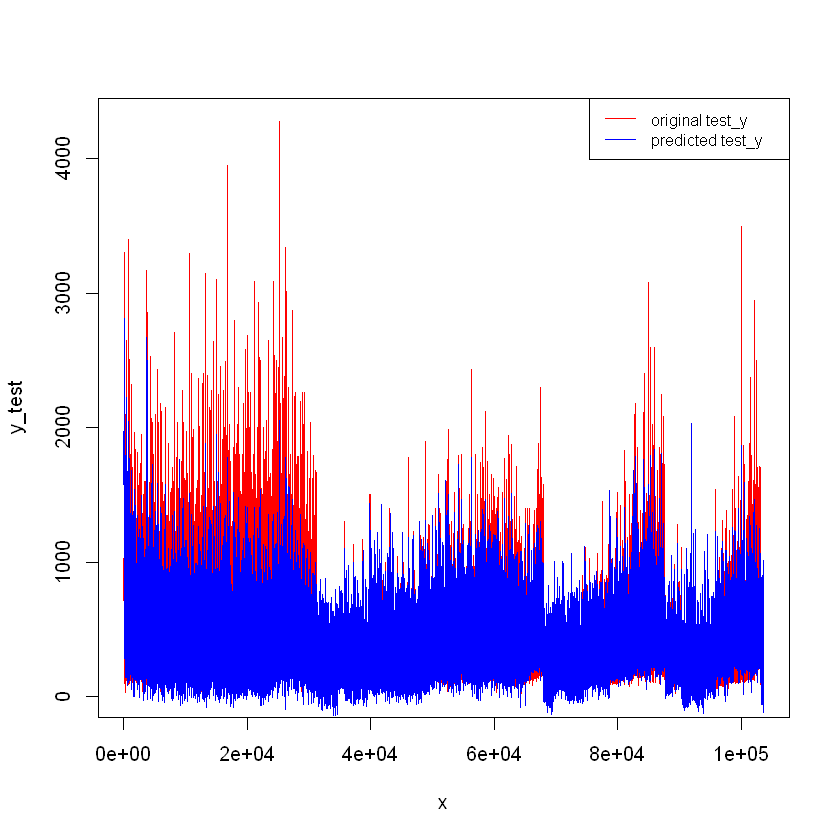

In [62]:
x = 1:length(y_test)
plot(x, y_test, col = "red", type = "l")
lines(x, pred_y_xgbr, col = "blue", type = "l")
legend("topright",  legend = c("original test_y", "predicted test_y"), 
       col = c("red", "blue"), box.lty = 1, cex = 0.8, lty = c(1, 1))

In [63]:
save(xgb.reg, file = "models/xgbr_model.rda")
save(xgb.reg, file = "../house-price-prediction-app/shinyApp/models/xgbr_model.rda")